# Домашнее задание 12

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from datetime import datetime

## Задание 1: Метод наименьших квадратов (4 балла).

Первая задача будет разминочной с игрушечной моделью, на которой можно
будет легко проверить ваши имплементации линейной регрессии и статистических
тестов для неё.
Вам представлены пары наблюдений $(X_i, Y_i)$, такие, что $Y_i$ – это некоторый полином от $X_i$ с точностью до Гауссовского шума с неизвестной дисперсией. То есть для некоторого $p \in \mathbb{N}$ верно, что $$Y_i = \sum_{k=0}^p \theta_k^* X_i^k + \varepsilon_i, \text{ }\varepsilon_i \sim \mathcal{N}(0,\,\sigma^2_p)$$
Считайте, что величины $\varepsilon_i$ независимы между собой, а также $\varepsilon_i$ не завсият от $X_i$.
Данные можно найти по следующей ссылке: https://disk.yandex.ru/d/iu95H0ZL1KuXTw.

**Задача 1 (2 балла)**. Имплементируйте функцию/класс построения оценки МНК
по произвольным данным. Не забудьте про константный признак!
Визуализируйте на одном графике получившиеся модели линейной регресии
при $p = 1, 2, 3, 5, 10, 25$ при помощи line plot и исходные данные в виде scatter plot. **Сделайте выводы.**

In [113]:
class LeastSquaresPolynomial:
  def __init__(self, p):
    self.p = p

  def fit_predict(self, X, Y):
    """
    return value: (theta, estimated Y)
    """
    self.psi = np.transpose(np.vander(X.reshape(-1), self.p + 1, increasing=True))
    self.theta = np.linalg.solve((self.psi @ np.transpose(self.psi)),
                                 self.psi @ Y.reshape(-1, 1)) # linalg.inv is bad here
    return (np.transpose(self.psi) @ self.theta).reshape(-1)

  def predict(self, X):
    self.last_psi = np.transpose(np.vander(X.reshape(-1), self.p + 1, increasing=True))
    return (np.transpose(self.last_psi) @ self.theta).reshape(-1)

In [114]:
link1 = "https://raw.githubusercontent.com/yukuk/statistics-hw/main/12/data.csv"
data1 = pd.read_csv(link1).to_numpy()
print(data1[:10])

[[0.         0.         0.52376655]
 [1.         0.02020202 0.63387445]
 [2.         0.04040404 0.51598294]
 [3.         0.06060606 0.55754801]
 [4.         0.08080808 0.51257093]
 [5.         0.1010101  0.7141333 ]
 [6.         0.12121212 0.82102674]
 [7.         0.14141414 0.38324838]
 [8.         0.16161616 0.75984197]
 [9.         0.18181818 0.25307229]]


In [115]:
data1 = data1[data1[:, 1].argsort()]
X = data1[:, 1]
Y = data1[:, 2]
n1 = len(data1)
INF = 10 ** 9

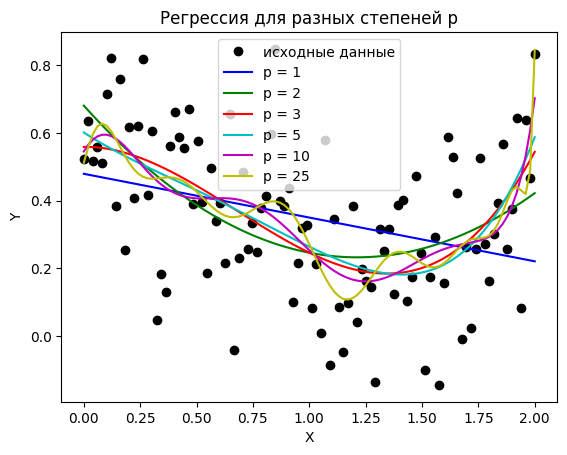

In [116]:
plt.plot(X, Y, 'ko', label="исходные данные")

colors = ['-b', '-g', '-r', '-c', '-m', '-y']
powers = [1, 2, 3, 5, 10, 25]
for color, power in zip(colors, powers):
  model = LeastSquaresPolynomial(power)
  plt.plot(X, model.fit_predict(X, Y), color, label=f"p = {power}")

plt.legend()
plt.title('Регрессия для разных степеней p')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Данные имеют не так много точек перегиба (если пытаться визуально приблизить их полиномом), поэтому использование больших показателей $p$ не представляет большого смысла/ скорее всего, стоит использовать степень 2-3. Проверим соответсвующую гипотезу в следующем пункте

**Задача 2 (1 балла).** Рассмотрите регрессию при $p = 25$. Проверьте гипотезy: $\theta_k^* = 0$ для всех $k ⩾ 10$ на уровене значимости $0.05$. Дисперсию считайте неизвестной. **Сделайте выводы.**

Выдвинем гипотезу $H_0:$  $\theta_k^* = 0$ для всех $k ⩾ 10$ и ее альтернативу $H_1:$ $\exists k \geqslant 10: \theta_k^* \neq 0$. Воспользуемся F-тестом, для этого посчитаем статистику:
$$\frac{(||Y - \hat{Y}_9||^2 - ||Y - \hat{Y}_{25}||^2)/16}{||Y - \hat{Y}_{25}||^2/(n - 26)}$$
где $\hat{Y}_i$ - соответсвующая оценка для модели со значением $p$, равным $i$

In [117]:
model9 = LeastSquaresPolynomial(9)
model25 = LeastSquaresPolynomial(25)
Y_9 = model9.fit_predict(X, Y)
Y_25 = model25.fit_predict(X, Y)
sq_sum = lambda arr: sum(list(np.square(arr)))
F_test1 = (sq_sum(Y - Y_9) - sq_sum(Y - Y_25)) / 16 / (sq_sum(Y - Y_25) / (n1  - 26))
print(F_test1)

0.2892079321658577


Отвергаем $H_0$, если значение полученной статистики больше, чем $\cal F$$(16, n - 26)_{0.95}$ (соответствующий квантиль распределения Фишера):

In [118]:
F_quantile1 = scipy.stats.f.ppf(0.95, 16, n1 - 26)
print(F_quantile1)

1.7821076547156105


Таким образом, мы принимаем гипотезу $H_0$. В следующем пункте попробуем найти оптимальную степень с помощью информационного критерия Акаике

**Задача 3 (1 балл).** Имплементируйте процедуру выбора степени многочлена
$p = 1, . . . , 25$ при помощи информационного критерия Акаике (AIC) и найдите оптимальную степень многочлена. **Сделайте выводы.**

Для оптимальной оценки $\sigma_m^2$ будем использовать несмещенную выборочную дисперсию. Так как шум имеет нормальное распределение по условию, оценка будет оптимальной. Чтобы добиться несмещнности, необоходимо передать в качестве параметра ddof функции np.var() количество строк матрицы $\psi$ нашей модели $m$

In [119]:
aic_opt = INF
m_opt = 0

for m in range(1, 26):
  model_m = LeastSquaresPolynomial(m)
  f_m = model_m.fit_predict(X, Y)
  aic_m = sq_sum(f_m - Y) + 2 * m * np.var(Y - f_m, ddof=m)
  print(f"AIC для p = {m}:", aic_m)
  if aic_m < aic_opt:
    aic_opt = aic_m
    m_opt = m
print("Оптимальный p:", m_opt)

AIC для p = 1: 4.893871427577521
AIC для p = 2: 4.0949394255048865
AIC для p = 3: 3.9231598818469386
AIC для p = 4: 3.975272645842764
AIC для p = 5: 4.055741941051478
AIC для p = 6: 4.130723306731682
AIC для p = 7: 4.091216857559735
AIC для p = 8: 4.174320974836673
AIC для p = 9: 4.257674404351235
AIC для p = 10: 4.3440196894426535
AIC для p = 11: 4.332616980756967
AIC для p = 12: 4.373949810269064
AIC для p = 13: 4.4701349347035935
AIC для p = 14: 4.617159429937251
AIC для p = 15: 4.708892714839319
AIC для p = 16: 4.735888623928267
AIC для p = 17: 4.920777896223604
AIC для p = 18: 4.989824080923185
AIC для p = 19: 5.487613782516314
AIC для p = 20: 4.972856164808754
AIC для p = 21: 5.620750982691357
AIC для p = 22: 5.233046438799601
AIC для p = 23: 2435.174262266643
AIC для p = 24: 5.4485642895083455
AIC для p = 25: 5.575634532289131
Оптимальный p: 3


Мы получили результат, совпадающий с нашими рассуждениями в начале

## Задание 2: Рекламные бюджеты (3 балла).

В данной задаче мы будем изучать влияние выделенного бюджета на продажу
на различных рынках. Данные можно найти по ссылке https://disk.yandex.ru/i/fpJurv0E7kGY9Q.
* Sales - продажи продукта на данном рынке (в тысячах штук);
* TV - доллары, потраченные на ТВ рекламу для одного продукта на данном
рынке (в тысячах долларов);
* Radio - доллары, потраченные на радио рекламу;
* Newspaper - доллары, потраченные на рекламу в газетах;

**Задание 1 (1 балл).** Постройте уравнение линейной регрессии, используя модель $$Sales_i = \theta_0^* + TV_i \cdot \theta_1^* + \varepsilon_i.$$
Вычислите $R^2$ для этой модели, проверьте гипотезу о значимости коэффициента
$\theta_1^*$ с уровнем значимости $0.05$. Визуализируйте на одном графике модель линейной регресии в виде line plot и исходные данные в виде scatter plot. Оцените визуально, действительно ли зависимость должна быть линейной?

In [120]:
link2 = "https://raw.githubusercontent.com/yukuk/statistics-hw/main/12/Advertising.csv"
data2 = pd.read_csv(link2).to_numpy()
print(data2[:10])

[[  1.  230.1  37.8  69.2  22.1]
 [  2.   44.5  39.3  45.1  10.4]
 [  3.   17.2  45.9  69.3   9.3]
 [  4.  151.5  41.3  58.5  18.5]
 [  5.  180.8  10.8  58.4  12.9]
 [  6.    8.7  48.9  75.    7.2]
 [  7.   57.5  32.8  23.5  11.8]
 [  8.  120.2  19.6  11.6  13.2]
 [  9.    8.6   2.1   1.    4.8]
 [ 10.  199.8   2.6  21.2  10.6]]


In [121]:
data2 = data2[data2[:, 1].argsort()]
Sales = data2[:, 4]
TV = data2[:, 1]
n2 = len(data2)

In [122]:
model = LeastSquaresPolynomial(1)
Sales_est = model.fit_predict(TV, Sales)
Sales_avg = np.ones(n2) * np.sum(Sales) / n2
R2 = 1 - sq_sum(Sales - Sales_est) / sq_sum(Sales - Sales_avg)
print(R2)

0.6118750508500709


Можно сказать, что данная модель МНК будет выдавать осмысленные результаты, тем не менее, с плохим качеством и неучетом других потенциальных параметров

Чтобы проверить гипотезу из условия, будем действовать аналогично 1.2:

In [123]:
F_test2 = (sq_sum(Sales - Sales_avg) - sq_sum(Sales - Sales_est)) / (sq_sum(Sales - Sales_est) / (n2  - 2))
print(F_test2)

312.14499437271274


In [124]:
F_quantile2 = scipy.stats.f.ppf(0.95, 1, n2 - 2)
print(F_quantile2)

3.8888529328918806


Мы отвергаем гипотезу $H_0$ - в текущей модели параметр $\theta_1$ является значимым

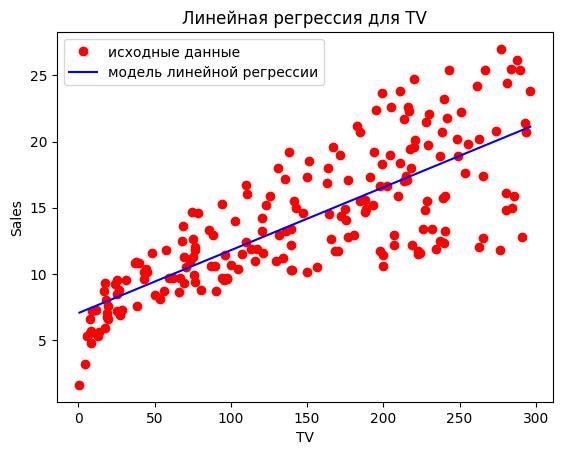

In [125]:
plt.plot(TV, Sales, 'ro', label="исходные данные")

plt.plot(TV, Sales_est, '-b', label=f"модель линейной регрессии")

plt.legend()
plt.title('Линейная регрессия для TV')
plt.xlabel('TV')
plt.ylabel('Sales')
plt.show()

Из графика совершенно точно видно, что $TV$ оказывает логарифмическое влияние на $Sales$

**Задание 2 (1 балл)**. Модифицируем модель, преобразов признаки как
$$log Sales_i = \theta_0^* + log TV_i \cdot \theta_1^* + \varepsilon_i.$$
Вычислите $R^2$ для новой модели, проверьте значимость $\theta_1^*$ и снова визуализируйте $Sales_i$ и получившуюся модель $\widehat{Sales_i}$. Стала ли модель лучше?

In [126]:
logSales = np.log(Sales)
logTV = np.log(TV)
logSales_est = model.fit_predict(logTV, logSales)
logSales_avg = np.ones(n2) * np.sum(logSales) / n2
logR2 = 1 - sq_sum(logSales - logSales_est) / sq_sum(logSales - logSales_avg)
print(logR2)

0.7421363059546484


$R^2$ стал больше, значит мы получаем более значимые результаты

In [127]:
logF_test2 = (sq_sum(logSales - logSales_avg) - sq_sum(logSales - logSales_est)) / (sq_sum(logSales - logSales_est) / (n2  - 2))
print(logF_test2)

569.8475278694211


In [128]:
print(F_quantile2)

3.8888529328918806


По-прежнему не можем принять $H_0$

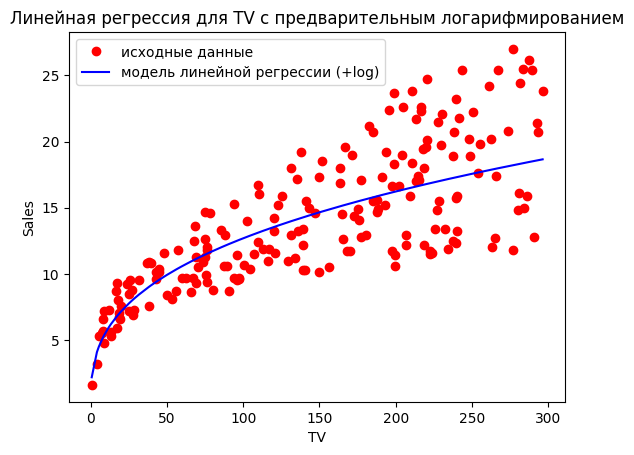

In [129]:
plt.plot(TV, Sales, 'ro', label="исходные данные")

plt.plot(TV, np.exp(logSales_est), '-b', label=f"модель линейной регрессии (+log)")

plt.legend()
plt.title('Линейная регрессия для TV c предварительным логарифмированием')
plt.xlabel('TV')
plt.ylabel('Sales')
plt.show()

Консистентность синих точек (исходных данных) и новой модели заметно лучше, что видно из графика выше

**Задание 3 (1 балл)**. Добавим оставшиеся переменные
$$log Sales_i = \theta_0^* + log TV_i \cdot \theta_1^* + Radio_i \cdot \theta_2^* + Newspaper_i \cdot \theta_3^* + \varepsilon_i$$
и обучим новую модель линейной регрессии. Вычислите $R^2$ и вычислите $0.05$-доверительные интервалы для всех коэффициентов. Стала ли модель лучше? Выгодно ли вкладывать деньги в рекламу в газетах? Почему? Какой вид рекламы самый эффективный?

In [130]:
class LeastSquaresMultiParam:
  def fit_predict(self, X_arr, Y):
    """
    return value: (theta, estimated Y)
    """
    self.psi = np.vstack((np.ones(len(Y)), *X_arr))
    self.theta = np.linalg.solve((self.psi @ np.transpose(self.psi)),
                                 self.psi @ Y.reshape(-1, 1)) # linalg.inv is bad here
    return (np.transpose(self.psi) @ self.theta).reshape(-1)

In [131]:
Radio = data2[:, 2]
Newspaper = data2[:, 3]

In [132]:
model = LeastSquaresMultiParam()
Sales_est_multi = model.fit_predict([TV, Radio, Newspaper], Sales)
R2_multi = 1 - sq_sum(Sales - Sales_est_multi) / sq_sum(Sales - Sales_avg)
print(R2_multi)

0.8972106381789521


$R^2$ показывает, что модель стала еще лучше и точнее

Гамма-доверительные интервалы для линейной регрессии вычисляются с помощью распределения Стьюдента:
$$\hat{\theta}_j \pm t(n - p - 1)_{\frac{1 - \alpha}{2}}se(\theta_j)$$
где $se(\theta_j)$ - стандартная ошибка, вычисляемая по формуле $\sqrt{\hat{\sigma}^2C_{jj}}$, $C = (\psi\psi^T)^{-1}$. Несложно это показать это из тех рассуждений, что $\mathbb{E}\hat{\theta_i} = \theta_i^*$, $\text{Var}\hat{\theta_i} = se(\theta_j)$.

В нашем случае, $p = 3$, $\alpha = 0.05$, а $\hat{\sigma}^2$ будем аналогично 1.3 вычислять как выборочную дисперсию с правильным смещением (будем пользоваться сходимостью к константе и тем самым сможем построить асимптотический интервал)

In [133]:
alpha = 0.05

for i in range(4):
  indent = scipy.stats.t.ppf((1 - alpha) / 2, n2 - 4) * \
          np.sqrt(np.linalg.inv(model.psi @ np.transpose(model.psi))[i][i] *
                  np.var(Sales - Sales_est_multi, ddof=4))
  print(f"Доверительный интервал для {i}-й координаты тета:",
        model.theta[i] - indent, model.theta[i] + indent)

Доверительный интервал для 0-й координаты тета: [2.95847319] [2.91930555]
Доверительный интервал для 1-й координаты тета: [0.04585223] [0.04567706]
Доверительный интервал для 2-й координаты тета: [0.18907069] [0.18798934]
Доверительный интервал для 3-й координаты тета: [-0.00066887] [-0.00140612]


Вкладывать деньги в рекламу в газетах невыгодно, так как она оказывает небольшое влияние, да еще и отрицательное (что можно утверждать с большой уверенностью, т.к. $\alpha = 0.05$). Самые эффективные показатели оказались у радио.

## Задание 3: Крах доллара (3 балла).

Вам представлены данные курса доллара USD-RUB за период 15 марта 2022 -
15 мая 2022 Найти их можно по следующей ссылке: https://disk.yandex.ru/d/OFu5yN7a4qvnIQ.
Описание столбцов данных:
* \<TICKER> Валютная пара (USD-RUB);
* \<PER> За какой промежуток данные (D=день)
* \<DATE> Дата в формате YYYYMMDD;
* \<TIME> Время (формат не важен);
* \<OPEN> Цена на открытии биржи;
* \<HIGH> Наибольшая цена в течение дня;
* \<LOW> Наименьшая цена в течение дня;
* \<CLOSE> Цена на закрытии биржи;

**Задача 1 (1 балла)**: Постройте оценку параметров методом наименьших квадратов для модели линейной регрессии $$<CLOSE> = \theta_0^* + \theta_1^* \cdot \Delta_{<DATE>} + \varepsilon, \mathbb{E}[\varepsilon] = 0,$$
где $\Delta_{<DATE>}$ – это количество дней, которое прошло с 15 марта 2022 года. Вычислите $R^2$. Визуализируйте вашу оценку на промежутке от 15 марта 2022 до 15 сентября 2022 в виде line plot и данные в виде scatter plot.

In [134]:
link3 = "https://raw.githubusercontent.com/yukuk/statistics-hw/main/12/USDRUB.csv"
data3 = pd.read_csv(link3, sep=';').to_numpy()
print(data3[:10])

[['USDRUB' 'D' 20220315 0 112.501 119.25 98.495 108.45 2388]
 ['USDRUB' 'D' 20220316 0 108.75 109.0 93.75 95.75 2441]
 ['USDRUB' 'D' 20220317 0 95.0 105.617 94.5 103.0754 1695]
 ['USDRUB' 'D' 20220318 0 95.625 107.25 95.625 103.0 2641]
 ['USDRUB' 'D' 20220320 0 101.1248 101.1248 100.35 101.0982 10]
 ['USDRUB' 'D' 20220321 0 104.817 107.5 103.25 106.6625 2704]
 ['USDRUB' 'D' 20220322 0 103.3 107.75 101.5 105.9931 2228]
 ['USDRUB' 'D' 20220323 0 105.6 106.25 93.5 96.7266 2594]
 ['USDRUB' 'D' 20220324 0 97.75 102.2572 94.625 102.2056 475]
 ['USDRUB' 'D' 20220325 0 100.25 101.25 96.4 101.25 815]]


In [135]:
CLOSE = data3[:, 7].astype(float)
DATE = data3[:, 2]
parse = lambda s: (datetime.strptime(str(s), "%Y%m%d").date() - datetime.strptime("20220315", "%Y%m%d").date()).days
vec_parse = np.vectorize(parse)
DELTA = vec_parse(DATE).astype(float)
n3 = len(data3)
print(DELTA)

[ 0.  1.  2.  3.  5.  6.  7.  8.  9. 10. 12. 13. 14. 15. 16. 17. 19. 20.
 21. 22. 23. 24. 26. 27. 28. 29. 30. 31. 33. 34. 35. 36. 37. 38. 40. 41.
 42. 43. 44. 45. 48. 49. 50. 51. 52. 55. 56. 57. 58. 59. 62.]


In [136]:
model = LeastSquaresPolynomial(1)
CLOSE_est = model.fit_predict(DELTA, CLOSE)
CLOSE_avg = np.ones(n3) * np.sum(CLOSE) / n3

R2_task3 = 1 - sq_sum(CLOSE - CLOSE_est) / sq_sum(CLOSE - CLOSE_avg)
print(R2_task3)

0.8729035715813139


$R^2$ получился довольно высоким. Тем не менее, надо учитывать, что мы не имеем досутпа к валидационной выборке, т.к. не умеем заглядывать в будущее, да и в задаче это не требуетя. В контексте временных рядов адекватность должна измеряться по-другому (скорее всего)

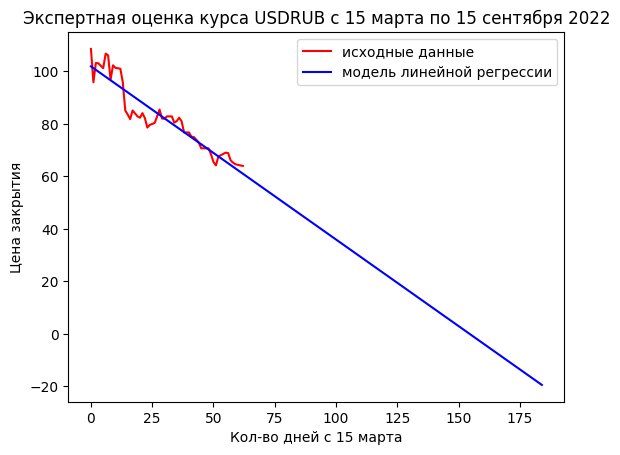

In [137]:
DELTA_long = np.array(list(range((datetime.strptime("20220916", "%Y%m%d").date() - datetime.strptime("20220315", "%Y%m%d").date()).days)))
CLOSE_long_est = model.predict(DELTA_long)

plt.plot(DELTA, CLOSE, '-r', label="исходные данные")
plt.plot(DELTA_long, CLOSE_long_est, '-b', label=f"модель линейной регрессии")

plt.legend()
plt.title('Экспертная оценка курса USDRUB с 15 марта по 15 сентября 2022')
plt.xlabel('Кол-во дней с 15 марта')
plt.ylabel('Цена закрытия')
plt.show()

**Задача 2(2 балла)**: Постройте $\gamma$-доверительный интервал на значение курса доллара во время закрытия биржи \<CLOSE> 1 сентября 2022, используя предположение модели. Значение $\gamma$ зафиксируйте как $0.95$.

Тут будет похожий интервал, использующий квантилти распределения Стьюдента, как в задании 2.3, но здесь имеет место быть так называемый *predictor interval*. Он выглядит следующим образом:
$$\hat{y} \pm t(n - p - 1)_{\frac{\gamma}{2}}\sqrt{\hat{\sigma}^2(1 + X^T(\psi\psi^T)^{-1}X)}$$, ($p = 1, \gamma = 0.95$)

In [138]:
gamma = 0.95

DELTA_one = np.array([(datetime.strptime("20220901", "%Y%m%d").date() - datetime.strptime("20220315", "%Y%m%d").date()).days])
CLOSE_one_est = model.predict(DELTA_one)

indent = scipy.stats.t.ppf(gamma / 2, n3 - 1) * \
         np.sqrt((1 + np.transpose(model.last_psi) @
                  np.linalg.inv(model.psi @ np.transpose(model.psi)) @
                  model.last_psi) *
                 np.var(CLOSE - CLOSE_est, ddof=1))
print(f"Доверительный интервал для цены закрытия 1-го сентября 2022:",
        CLOSE_one_est - indent, CLOSE_one_est + indent)

Доверительный интервал для цены закрытия 1-го сентября 2022: [[-9.88101037]] [[-10.73374517]]


Слова излишни. А если серьезно, то мы не могли получить другой результат в рамках выбранной модели. Взяв небольшой участок курса, на котором он падает, и построив линейное приближение, я так и понял, что мы увидим прямую, которая рано или поздно достигнет нуля, да и отрицательных значений тоже
